### Imports

In [4]:
import numpy as np
import os.path as path
import torch
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from models import Cifar10Net
from dataset_utils import getCIFAR10
import seaborn as sns

### Variables

In [5]:
CIFAR_10_DATA_PATH = 'data/cifar-10-batches-py/'

### Helper functions

In [6]:
class ExperimentConfig:
    def __init__(
        self,
        num_rounds=1,        
        sample_fraction_fit=1.0, 
        num_clients=100,
        strategy='fedAvg',
        beta=0.5,
        lr=0.01,
        mu=5,
        seed=0
    ):
        self.num_rounds = num_rounds
        self.sample_fraction_fit = sample_fraction_fit
        self.num_clients = num_clients
        self.strategy = strategy
        self.beta = beta
        self.lr = lr
        self.mu = mu
        self.seed = seed
        
    def experiment_id(self):
        return str(self.num_rounds) + "_rnd_" + str(self.sample_fraction_fit) + "_frac_" + str(self.num_clients) + "_cli_" \
                + self.strategy + "_" + str(self.beta) + "_b_" + str(self.lr) + "_lr_" \
                + str(self.mu) + "_mu_" + str(self.seed) + "_seed"

In [7]:
def load_metrics(config, data_path, centralised=True):
    if centralised:
        accs = np.load(path.join(data_path, config.experiment_id(), 'accs_centralized.npy'))
        losses = np.load(path.join(data_path, config.experiment_id(), 'loss_centralized.npy'))
    else:
        accs = np.load(path.join(data_path, config.experiment_id(), 'accs_distributed.npy'))
        losses = np.load(path.join(data_path, config.experiment_id(), 'loss_distributed.npy'))
    return accs, losses

In [8]:
def final_model_state_dict(config, data_path):
    return torch.load(path.join(data_path, config.experiment_id(), 'final_model.pt'))

# Basic experiment

Comparing `MOON` and `FedAvg` on 10 clients, 100 rounds.

## Selecting the best learning rate

We have noticed that with the proposed learning rate in the paper (`lr=0.01`) the model was not learning at all. Therefore we designed a small hyperparameter search for the learning rate.

The following learning rates were evaluated on `fedAvg`: `[0.01, 0.005, 0.001, 0.0005, 0.0001]`

In [31]:
base_config = ExperimentConfig(
    num_rounds=100,
    num_clients=10,
)

last_round_accs = {}
last_round_losses = {}

lrs = [0.01, 0.005, 0.001, 0.0005, 0.0001]
for lr in lrs:
    base_config.lr = lr  
    accs_centralised, losses_centralised = load_metrics(base_config, CIFAR_10_DATA_PATH)
    last_round_accs[lr] = accs_centralised[-1]
    last_round_losses[lr] = losses_centralised[-1]

In [32]:
print("Last round accuracies: ", last_round_accs)
print("Last round losses: ", last_round_losses)

Last round accuracies:  {0.01: 0.1, 0.005: 0.1, 0.001: 0.5316, 0.0005: 0.5224, 0.0001: 0.4712}
Last round losses:  {0.01: 0.04671479940414429, 0.005: nan, 0.001: 0.026626469147205352, 0.0005: 0.026587545192241668, 0.0001: 0.029388115096092224}


Best learning rate is `0.001`.

## Experiment

In [52]:
base_config = ExperimentConfig(
    num_rounds=100,
    num_clients=10,
    lr=0.001,
)

seeds = range(1,4)

basic_accuracies = {}

for strat in ['moon', 'fedAvg']:
    last_accs = []
    for s in seeds:
        base_config.seed = s
        base_config.strategy = strat
        accs_centralised, _ = load_metrics(base_config, CIFAR_10_DATA_PATH)
        last_accs.append(accs_centralised[-1])
    basic_accuracies[strat] = last_accs
basic_accuracies['seeds'] = seeds
basic_accs_df = pd.DataFrame.from_dict(basic_accuracies)
basic_accs_df.index = basic_accs_df['seeds']
basic_accs_df.drop(columns='seeds', inplace=True)

In [53]:
basic_accs_df

,moon,fedAvg
seeds,,
1,0.4687,0.4994
2,0.4899,0.5558
3,0.4667,0.5384


In [58]:
basic_accs_df.describe()

,moon,fedAvg
count,3.000000,3.000000
mean,0.475100,0.531200
std,0.012856,0.028881
min,0.466700,0.499400
25%,0.467700,0.518900
50%,0.468700,0.538400
75%,0.479300,0.547100
max,0.489900,0.555800


In [62]:
loss_dfs = {}
for strat in ['moon', 'fedAvg']:
    losses = {}
    for s in seeds:
        base_config.seed = s
        base_config.strategy = strat
        _, losses_centralized = load_metrics(base_config, CIFAR_10_DATA_PATH)
        losses[s] = losses_centralized
    df = pd.DataFrame.from_dict(losses, orient='index')
    loss_dfs[strat] = df

<AxesSubplot:title={'center':'Moon average loss'}, xlabel='round', ylabel='loss'>

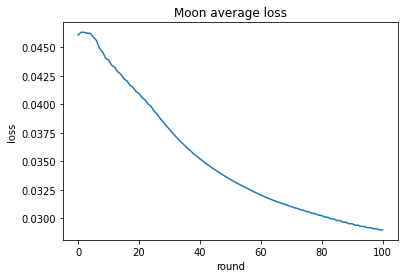

In [68]:
loss_dfs['moon'].mean().plot(xlabel='round', ylabel='loss', title='Moon average loss')

<AxesSubplot:title={'center':'FedAvg average loss'}, xlabel='round', ylabel='loss'>

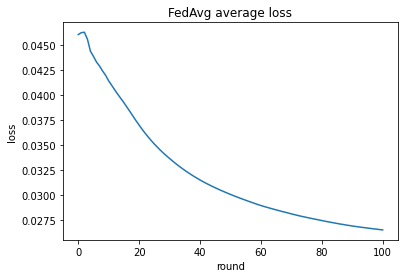

In [69]:
loss_dfs['fedAvg'].mean().plot(xlabel='round', ylabel='loss', title='FedAvg average loss')

# Visualization

Input representations with T-SNE.

In [87]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [84]:
# From: https://kozodoi.me/python/deep%20learning/pytorch/tutorial/2021/05/27/extracting-features.html
##### HELPER FUNCTION FOR FEATURE EXTRACTION

def get_features(name):
    def hook(model, input, output):
        features[name] = output.detach()
    return hook

## MOON

In [123]:
base_config.strategy = 'moon'

model = Cifar10Net()
model.load_state_dict(final_model_state_dict(base_config, CIFAR_10_DATA_PATH))
model.to(device)

model

Cifar10Net(
  (encoder): CifarEncoder(
    (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
    (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
    (fc1): Linear(in_features=400, out_features=120, bias=True)
    (fc2): Linear(in_features=120, out_features=84, bias=True)
  )
  (projection_head): MLPProjectionHead(
    (l1): Linear(in_features=84, out_features=84, bias=True)
    (l2): Linear(in_features=84, out_features=256, bias=True)
  )
  (output_layer): OutputLayer(
    (l): Linear(in_features=256, out_features=10, bias=True)
  )
)

In [124]:
##### REGISTER HOOK

model.projection_head.l2.register_forward_hook(get_features('feats'))

In [125]:
_, test_data = getCIFAR10()

testloader = torch.utils.data.DataLoader(test_data, batch_size=50)

##### FEATURE EXTRACTION LOOP

# placeholders
FEATS = []

# placeholder for batch features
features = {}

# loop through batches
for idx, (x, target) in enumerate(testloader):

    # move to device
    x, target = x.to(device), target.to(device)
       
    # forward pass [with feature extraction]
    preds = model(x)
    
    # add feats and preds to lists
    FEATS.append(features['feats'].cpu().numpy())

Files already downloaded and verified
Generating unified CIFAR dataset


In [126]:
##### INSPECT FEATURES

FEATS = np.concatenate(FEATS)

print('- feats shape:', FEATS.shape)

- feats shape: (10000, 256)


/home/mr892/.cache/pypoetry/virtualenvs/moon-9vN7PLyC-py3.8/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/mr892/.cache/pypoetry/virtualenvs/moon-9vN7PLyC-py3.8/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[Text(0.5, 1.0, 'CIFAR-10 projection head output T-SNE projection (MOON)')]

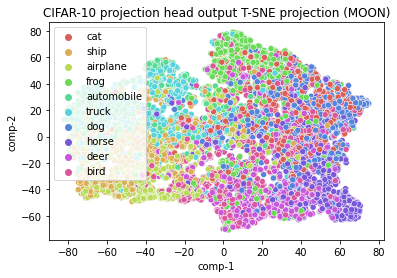

In [127]:
tsne = TSNE(n_components=2, random_state=0)
X_2d = tsne.fit_transform(FEATS)

df = pd.DataFrame()
df["y"] = [test_data.classes[i] for i in test_data.targets]
df["comp-1"] = X_2d[:,0]
df["comp-2"] = X_2d[:,1]

sns.scatterplot(x="comp-1", y="comp-2", hue=df.y.tolist(),
                palette=sns.color_palette("hls", 10),
                data=df).set(title="CIFAR-10 projection head output T-SNE projection (MOON)") 

## FedAvg

- feats shape: (10000, 256)


/home/mr892/.cache/pypoetry/virtualenvs/moon-9vN7PLyC-py3.8/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/mr892/.cache/pypoetry/virtualenvs/moon-9vN7PLyC-py3.8/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[Text(0.5, 1.0, 'CIFAR-10 projection head output T-SNE projection (FedAvg)')]

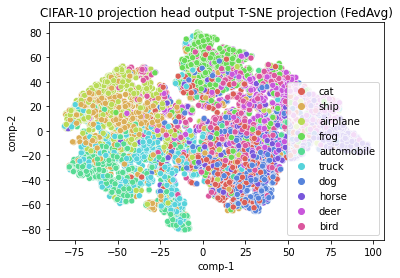

In [122]:
base_config.strategy = 'fedAvg'

model = Cifar10Net()
model.load_state_dict(final_model_state_dict(base_config, CIFAR_10_DATA_PATH))
model.to(device)

model.projection_head.l2.register_forward_hook(get_features('feats'))

# placeholders
FEATS = []

# placeholder for batch features
features = {}

# loop through batches
for idx, (x, target) in enumerate(testloader):

    # move to device
    x, target = x.to(device), target.to(device)
       
    # forward pass [with feature extraction]
    preds = model(x)
    
    # add feats and preds to lists
    FEATS.append(features['feats'].cpu().numpy())
    
FEATS = np.concatenate(FEATS)

print('- feats shape:', FEATS.shape)
    
tsne = TSNE(n_components=2, random_state=0)
X_2d = tsne.fit_transform(FEATS)

df = pd.DataFrame()
df["y"] = [test_data.classes[i] for i in test_data.targets]
df["comp-1"] = X_2d[:,0]
df["comp-2"] = X_2d[:,1]

sns.scatterplot(x="comp-1", y="comp-2", hue=df.y.tolist(),
                palette=sns.color_palette("hls", 10),
                data=df).set(title="CIFAR-10 projection head output T-SNE projection (FedAvg)") 

## Finding the best mu

In [9]:
base_config = ExperimentConfig(
    num_rounds=100,
    num_clients=10,
    strategy='moon',
    lr=0.001
)

last_round_accs = {}
last_round_losses = {}

mus = [0.1, 1.0, 3.0, 7.0]
for mu in mus:
    base_config.mu = mu  
    accs_centralised, losses_centralised = load_metrics(base_config, CIFAR_10_DATA_PATH)
    last_round_accs[mu] = accs_centralised[-1]
    last_round_losses[mu] = losses_centralised[-1]
    
print("Last round accuracies: ", last_round_accs)
print("Last round losses: ", last_round_losses)

Last round accuracies:  {0.1: 0.5202, 1.0: 0.491, 3.0: 0.4783, 7.0: 0.4678}
Last round losses:  {0.1: 0.027109568721055983, 1.0: 0.027988360488414764, 3.0: 0.028684879982471465, 7.0: 0.029150243175029754}


Text(0, 0.5, 'accuracy')

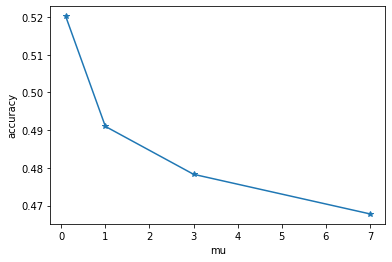

In [16]:
plt.plot(last_round_accs.keys(), last_round_accs.values(), '*-')
plt.xlabel('mu')
plt.ylabel('accuracy')

Text(0, 0.5, 'loss')

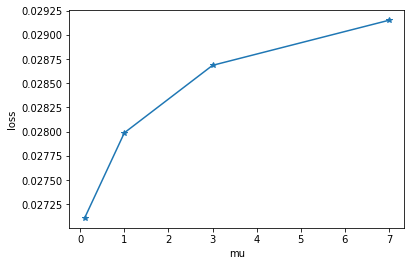

In [17]:
plt.plot(last_round_losses.keys(), last_round_losses.values(), '*-')
plt.xlabel('mu')
plt.ylabel('loss')

# Heterogeneity experiment

In [27]:
base_config = ExperimentConfig(
    num_rounds=100,
    num_clients=10,
    lr=0.001,
)

seeds = range(1,4)
betas = [0.1, 0.5, 5.0]

heterogeneity_accuracies = {}

last_accs = []
strategies = []
betas_list = []
seeds_list = []
for strat in ['moon', 'fedAvg']:
    for b in betas:
        for s in seeds:
            base_config.seed = s
            base_config.beta = b
            base_config.strategy = strat
            accs_centralised, _ = load_metrics(base_config, CIFAR_10_DATA_PATH)
            last_accs.append(accs_centralised[-1])
            strategies.append(strat)
            betas_list.append(b)
            seeds_list.append(s)
heterogeneity_accuracies['accuracy'] = last_accs
heterogeneity_accuracies['strategy'] = strategies
heterogeneity_accuracies['beta'] = betas_list
heterogeneity_accuracies['seeds'] = seeds_list
heterogeneity_accs_df = pd.DataFrame.from_dict(heterogeneity_accuracies)
heterogeneity_accs_df.index = heterogeneity_accs_df['seeds']
heterogeneity_accs_df.drop(columns='seeds', inplace=True)

In [28]:
heterogeneity_accs_df

,accuracy,strategy,beta
seeds,,,
1,0.4138,moon,0.1
2,0.3784,moon,0.1
3,0.3683,moon,0.1
1,0.4687,moon,0.5
2,0.4899,moon,0.5
3,0.4667,moon,0.5
1,0.5234,moon,5.0
2,0.5357,moon,5.0
3,0.5378,moon,5.0


In [31]:
heterogeneity_accs_df.groupby(['strategy', 'beta']).mean()

accuracy
strategy beta          
fedAvg   0.1   0.413500
         0.5   0.531200
         5.0   0.567233
moon     0.1   0.386833
         0.5   0.475100
         5.0   0.532300